In [15]:
import numpy as np

sample_size = 2518

# generate synthetic data with pattern
with open('data.csv', 'w') as f:
    f.write('time,data\n')
    for i in range(sample_size):
        i -= sample_size / 2
        rad = np.deg2rad(2*i)
        y = np.sin(rad) + 100 * (i * i * i/ sample_size / sample_size / sample_size)
        f.write(f'{i},{y}\n')

In [16]:
import pandas as pd
import torch
print(torch.cuda.is_available())
from chronos import BaseChronosPipeline

prediction_len = 200

pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-bolt-base",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

df = pd.read_csv('data.csv')

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# Chronos-Bolt models generate quantile forecasts, so forecast has shape
# [num_series, num_quantiles, prediction_length].
forecast = pipeline.predict(
    context=torch.tensor(df["data"]), prediction_length=prediction_len
)



True


D:\Documents\Programming\Python\Chronos\.venv\Lib\site-packages\chronos\chronos_bolt.py:527: UserWarning: We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
  warnings.warn(msg)


In [17]:
forecast.mean(dim=1).squeeze()

m = torch.stack([
    torch.tensor([x + sample_size for x in range(prediction_len)]).float(),
    forecast.mean(dim=1).squeeze()
])

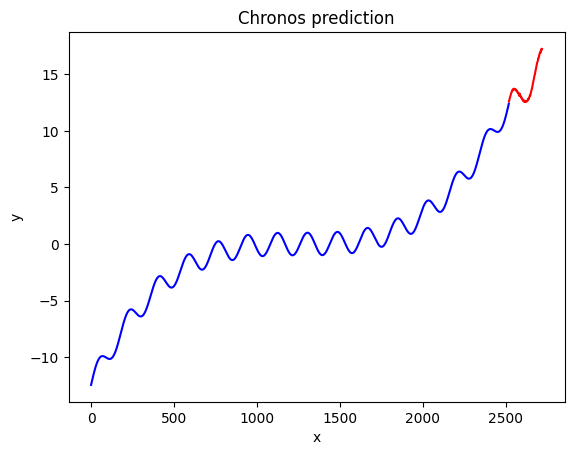

In [18]:
import matplotlib.pyplot as plt

plt.plot(df['data'], color='blue')
plt.plot(m[0], m[1], color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Chronos prediction')
plt.show()

In [6]:
# extracting the underlying model
chronos_bolt_model = pipeline.model

In [7]:
type(chronos_bolt_model)

chronos.chronos_bolt.ChronosBoltModelForForecasting

In [8]:
# model architecture
print(chronos_bolt_model)

ChronosBoltModelForForecasting(
  (shared): Embedding(2, 768)
  (input_patch_embedding): ResidualBlock(
    (dropout): Dropout(p=0.1, inplace=False)
    (hidden_layer): Linear(in_features=32, out_features=3072, bias=True)
    (act): ReLU()
    (output_layer): Linear(in_features=3072, out_features=768, bias=True)
    (residual_layer): Linear(in_features=32, out_features=768, bias=True)
  )
  (patch): Patch()
  (instance_norm): InstanceNorm()
  (encoder): T5Stack(
    (embed_tokens): Embedding(2, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding

In [14]:
# show that the architecture is subclass of nn.Module
print(type(chronos_bolt_model.output_patch_embedding.output_layer))
print(type(chronos_bolt_model.output_patch_embedding.residual_layer))

<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.linear.Linear'>
